# MODFLOW 2005 Example - Toth Flow

In this jupter notebook we'll demonstrate the use of flopy, to model two different solutions for groundwater basin flow developed by Joe Toth.  

Papers of reference for this excercise:
1. Tóth, J. (1962). A theory of groundwater motion in small drainage basins in central {Alberta, Canada}. Journal of Geophysical Research, 67(11), 4375–4388. https://doi.org/10.1029/JZ067i011p04375
2. Tóth, J. (1963). A theoretical analysis of groundwater flow in small drainage basins. Journal of Geophysical Research, 68(16), 4795–4812. Retrieved from http://dx.doi.org/10.1029/JZ068i016p04795
3. Harbaugh, A. W., & Harbaugh, Arlen, W. (2005). MODFLOW-2005 , The U . S . Geological Survey Modular Ground-Water Model — the Ground-Water Flow Process. U.S. Geological Survey Techniques and Methods, Ch. A16.

### Modeling with MODFLOW and Flopy
Right now its important to take some time to try and clarify what flopy and modflow are, and what there relationship is.  

#### The Simulator - MODFLOW
Modflow is a modular code, meaning vavious processes and features are added as needed.  In modflow this is done through the use of "packages".  We'll go about defining all the packages we need to implement the above conditions.   However,  I STRONGLY recommend having both the Modflow 2005 [Manual](https://pubs.usgs.gov/tm/2005/tm6A16) (Harbaugh 2005) and the [online guide](https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html) open any time you are modeling. 

First lets discuss MODFLOW.  MODFLOW is a standalone, exectuable program we have installed on our computer.  SO, MODLOW is the simulator of Groundwater flow.  MODFLOW can be executed at the command prompt on your computer, or run by double clicking in Windows.  This executable is written in FORTRAN, and does not need flopy to run at all.  What it does need is a series of input files that give MODFLOW instructions on how to setup and run the simulation - e.g. what packages to use, and the information each package needs.  When MODFLOW is run, it reads the input files, sets up all the required data arrays, performs the calculations, and writes output to the requested output files.  

MODFLOW input files can be written by hand with a text editor, but need to conform to certain guidlines (given in the online guide).  So, all you really need to run a MODFLOW simulation is a simple text editor, and the MODFLOW program.  However, writing this input files in the correct format can be time-consuming and cumbersome, so most simultions are done with some form of a pre-processor.  Pre-processors come in a varity of forms, but in the industry, they are commonly Graphical User Interfaces (GUIs). GUI's have the advantage of appealing to our visual learning brains, and can be very powerful.  The disadvantage, is that GUI capabilities are limited to what currently exists in the code base, and that because models are built with a series of points and clicks, there is no clear trail of how the model was built.  Additionally, these GUI's are useually commercial software, closed-source and can be very expensive.

After MODFLOW runs, it writes output to a variety of different files.  This output, is the model results, and in order to use this output for making figures and/or calculations, we require a post-processor.  Again, most post-processors in the industry are GUIs, which have powerful built-in capabilities, with the same limitations discussed above. 

#### The Pre- and Post-Processor - FloPy
Now, lets discuss FloPy.  Flopy is a python library that provides pre and post processesing functionality for a variety of MODFLOW versions.  It has functions for defining and writing input files.  It has functionality to then execute MODFLOW from within python (you don't need this at all, its just convienient).  And Flopy has functionality to read MODFLOW output into useful python data types, as well as methods that leverage python vizualization libraries to make figures.  

The disadvantage of Flopy is that the interface is lowerlevel, meaning you have to write you own code to do the pre-processing.  This means, you can't point and click, and you have to learn to program.  In other words, its harder.  However, it has many huge advantages.  First, its free, and can be installed on any computer running any OS, with virtually any hardware.  Secondly, at the expense of ease, comes freedom, flexibility and power.  With Flopy, programmers can use all the immense capabality of other python packages to build, manipulate and analyze model outputs.  For the most part, the limitations are closer to your imagination and technical chops.  

A third advantage of modeling with Flopy, is that the code leaves a record of exactly how we made our model.  This increases tranparency and tranferability of models, model workflows and model interpretations.

Finally, learning to model with a lower level interface, requires you learn more about the modeling process, and is very benificial to learning the art and science behind modeling.

### Toth 1962 Conceptual Model
In the first, taken after Toth 1962, the concept of a groundwater basin with a linearly sloping watertable is simulated. The model is for a 2D xsection of a single side of a groundwater basin.  Groundwater divides provide no lateral flow boundaries, a deep no flow boundary due to low K limits the vertical depth of circulation, and the head along the top of the model is set to be constant a fall along a linear slope.  The image of the conceptual model taken from Toth 1962 is given below.  A proper conceptual model should include all the ingredients necessary to solve the Boundary Value Problem for the given system.

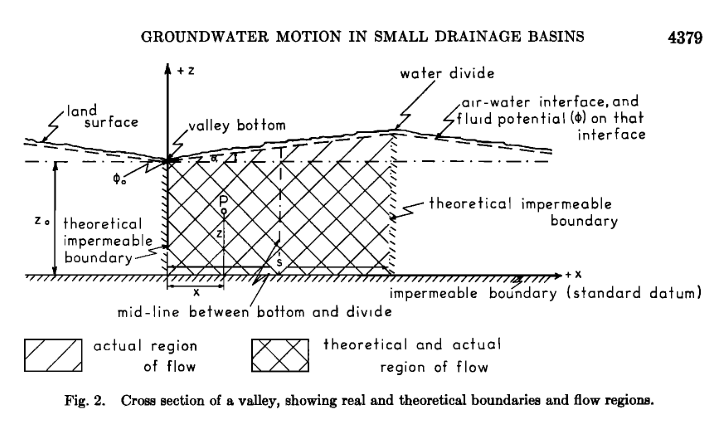

##### Boundary and Initial Conditions
Mathematically the boundary conditions are:

Constant head across the top with linear slope $c$.
$$h = h_o + c x, z=z_o$$
No lateral flow at west and east boundaries:
$$\frac{\partial h}{\partial x}=0, x=0,s$$
No vertical flow at the base:
$$\frac{\partial h}{\partial z}=0, z=0$$

The model is for steady state conditions, so initial conditions should not affect the result.

##### Domain of Interest
The head is modeled for a 2-D x-z slice of length $x = 20,000 ft$, depth $z_o = 10,000 ft$.  
##### Governing Equation
In general Modflow solves the 3D fully saturated groundwater flow equation:
$$
S_s\frac{\partial h}{\partial t} = \nabla\cdot(\nabla \cdot \bar{K}h)
$$
where $S_s$ is the specfic storage of the material (1/L), $\bar{K}$ is the hydraulic conductivity tensor assuming allignment of the principal flow and conductivity tensor directions (L/t), and $h$ is the hydraulic head (L).



Given the boundary conditions and domain above this equation reduces to:
$$
\nabla^2h=0
$$
however, MODFLOW basically always solves the more complex case (except you can get rid of the LHS for a steady state simulation).
##### Parameterization
The subsurface is considered homogenous and isotopic.  Because the model is steady state and homogenous, the hydraulic conductivity and specific storage will not matter to the solution as the governing equation simplifies to the 2D LaPlacian.
## MODFLOW Solution
First lets discuss just a bit of background terminology. 

#### Modflow 2005 Spatial Discretization
Modflow 2005 is a finite difference code.  It linearizes the groundwater flow equation above over discrete steps in space and time.  The spatial discretization scheme is shown in the figure below.  The world according to MODFLOW is broken up into stacked, horizontal layers. Each layer has a set rows along the nominal x-direction and columns along the nominal y-direction.  These layers, rows and columns divide the earth up into a system of cells.  The location of the cell is given by the $(layer, row, column) = (k,i,j)$.  Each cell has a length in x-direction given as $\Delta c_j$ and length in the y-direction given as $\Delta r_i$, and a layer thicknes of $\Delta v_k$.

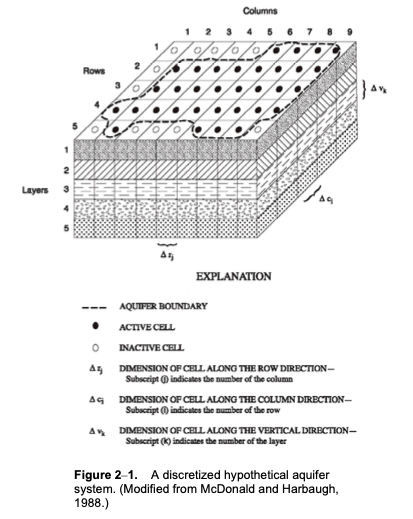

#### Modflow 2005 Temporal Discretization
For transient solutions, modflow simulates the temporal evolution of groundwater head.  Time is broken up into one or more **stress periods**.  Over each stress period - the boundary conditions are constant - and the head evolution over the stress period will be solved for a series of **time steps**.  In order to solve the updated head at the next time step, MODFLOW uses an iterative method, commonly a congugate gradient method, but can also be a Newton-Rapherson method (NWT) for more more non-linear problems.  An image of the general head updating is given below.

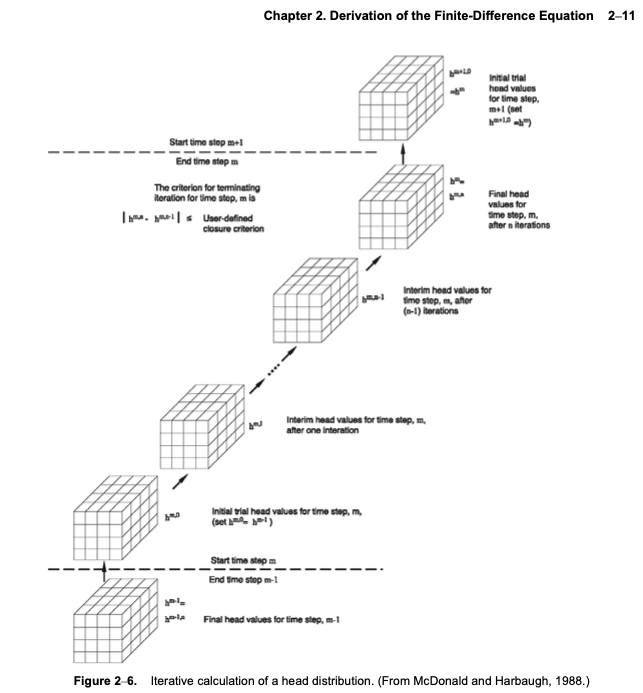

#### Boundary Conditions
Boundary conditions are one of the most critical pieces of modeling.  At the end of the day, the boundary condition is responsible for model behavior, and getting the boundary condition correct and reasonable is one of the hardest and most fundamental parts of models.  Its absolutely critital that we know how to implement the different kinds of boundary conditions.  At the end of the day there are three fundamental *types* of boundary condition for the groundwater flow equation above:
1. Defined head - $h(\bar{x})=f(t)$ where $\bar{x}=\Gamma_i$ and $\Gamma_i$ is a defined boundary.  Dirichlet B.C.
2. Defined head gradient (defined flux) - $\frac{\partial h}{\partial x}|_x = f(t)$, where $\bar{x}=\Gamma_i$ and $\Gamma_i$ is a defined boundary. Neumann B.C.
3. Mixed type - e.g. $\alpha(\bar{x}) + \beta\frac{\partial h}{\partial x}|_x= f(t)$, where $\bar{x}=\Gamma_i$ and $\Gamma_i$ is a defined boundary. Robin B.C.

Every code does this differently, but in Modflow, first type B.C.s are implemented through the basic package and use of the *ibound* array and 2nd and 3rd type boundaries are implemented using packages such as the Recharge or River package respectively.

### Modflow Packages
A Modflow simulation is put together by combining different packages the provide the required process sophistication.  At the bare minimum modflow needs
1. Basic Package
2. Discretization Package
3. Groundwater flow package (e.g. BCF, LPF, ...)
4. A solver package (e.g. PCG)
And since a model is not very useful with out output, usually you'll want
5. The output package

Other packages add optional functionality.  There are a bunch, and they are robust and useful.  This package construction is one of the reasons modflow has been so useful and successful.   We're solving a very basic problem here, so we'll only use the most basic packages in this simulation.  Now we'll go about defining the input and then writing input files and running modflow to simulate this conceptual model.

In [1]:
#first import libraries used in this notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pdb
import flopy
import os
import sys
import flopy.utils.binaryfile as bf

#always a good idea to know what versions you are working with
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
numpy version: 1.23.5
matplotlib version: 3.6.2
flopy version: 3.3.5


File management is crucial in modeling.  You end up writing tons of files, for different models with different tweaks.  Python can be used to help with file management.  Here, we'll define some paths, and decide whether we need to create a new directory for this model, and if we do create it.

In [2]:
#top level directory
homepath = os.getcwd()

# Path to the model working directory
dirname = "toth_linear"
modelpath = os.path.join(homepath, dirname)

print('Name of model path: ', modelpath)

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print('Model working directory already exists.')
else:
    print('Creating model working directory.')
    os.mkdir(modelpath)

Name of model path:  /Users/wpgardner/class/UH_HydroGeo/Assignments/Assignment5/toth_linear
Model working directory already exists.


##### Create the flopy modflow object.  
This is the main object which holds data and has methods for pre and post processing the modflow model.  The exe_name should point to your copy of mf2005. For a "nix" based machine you'll need to add "./" . For a windows, I think you just want "mf2005".

In [3]:
# Flopy objects
modelname = 'tothe'
mf = flopy.modflow.Modflow(modelname, exe_name='/opt/local/bin/mf2005',model_ws=modelpath)

##### Discretization Package

Discretize in space and time.  First we need to decide steady state vs. transient, which determines the time discretization.  Since this model is steady state, we don't need to define any time descritization.  In this case, we will mainly set up the model geometery and define the grid.

We'll consider the Toth model  dimensions from above, and make it so we have a grid with 1 row, 60 columns and 30 layers, which gives roughly 100mx100m cell dimensions.

In [4]:
#Uncomment below to get a description and help on the ModflowDis object
#flopy.modflow.ModflowDis?

In [5]:
#####################################
#Spatial Discretization
#####################################

# Model domain and grid definition
Lx = 20000./3.28 #length in m
Ly = 100. #this can be anything but keeping things pretty close to a cube is usually reasonable.
ztop = 0.0 #surface elevation is zero - can be anything 
zbot = -1*10000/3.28 #-10000 ft in m
nlay = 30
nrow = 1
ncol = 60
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
print('Cell size (dx,dy,dz) = (%1.4g,%1.4g,%1.4g)' %(delr,delc,delv))

# Modflow needs an array with the bottom elevation of each layer 
botm = np.linspace(ztop, zbot, nlay + 1)
print(botm)
#pdb.set_trace()

Cell size (dx,dy,dz) = (101.6,100,101.6)
[    0.          -101.62601626  -203.25203252  -304.87804878
  -406.50406504  -508.1300813   -609.75609756  -711.38211382
  -813.00813008  -914.63414634 -1016.2601626  -1117.88617886
 -1219.51219512 -1321.13821138 -1422.76422764 -1524.3902439
 -1626.01626016 -1727.64227642 -1829.26829268 -1930.89430894
 -2032.5203252  -2134.14634146 -2235.77235772 -2337.39837398
 -2439.02439024 -2540.6504065  -2642.27642276 -2743.90243902
 -2845.52845528 -2947.15447154 -3048.7804878 ]


In [6]:
#####################################
#Temporal Discretization
#####################################

# Time step parameters - thes are just dummies if steady=True
nper = 1
perlen = [100]
nstp = [100]
steady = [True]

In [7]:
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm[1:],
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady)

#### Basic Package
The basic package includes, intitial conditions - through the strt array, and defines active and non-active cells.  It is also used to define constant head boundary conditions.  Active, non-active and constant heads are defined with the ibound array.

Ibound=1 -> active cell


Ibound=0 -> inactive cell


Ibound=-1 -> constant head

In [8]:
#Uncomment below to get a description and help on the ModflowDis object
#flopy.modflow.ModflowBas?

In [9]:
# Variables for the BAS package

#define cells types with ibound
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[0, :, :] = -1 #layer, row, column
print(ibound)

#initial conditions - this doesn't matter for now, but it should be something reasonable
ho = 10
strt = ho * np.ones((nlay, nrow, ncol), dtype=np.float32)

#now for the linearly sloping upper boundary condition.  We want to keep everything fully saturated, 
# so I'll add the ho to the top elevation (zo=0) and then add the slope from there.

slp = 0.05
#apply across the top
for i in range(ncol):
    x = i*delc+(delc/2)
    #print(x)
    h_x = ho+slp*x
    strt[0,0,i]=h_x
    

#strt[:, :, 0] = 15.
print(strt)
#pdb.set_trace()
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

[[[-1 -1 -1 ... -1 -1 -1]]

 [[ 1  1  1 ...  1  1  1]]

 [[ 1  1  1 ...  1  1  1]]

 ...

 [[ 1  1  1 ...  1  1  1]]

 [[ 1  1  1 ...  1  1  1]]

 [[ 1  1  1 ...  1  1  1]]]
[[[ 12.5  17.5  22.5 ... 297.5 302.5 307.5]]

 [[ 10.   10.   10.  ...  10.   10.   10. ]]

 [[ 10.   10.   10.  ...  10.   10.   10. ]]

 ...

 [[ 10.   10.   10.  ...  10.   10.   10. ]]

 [[ 10.   10.   10.  ...  10.   10.   10. ]]

 [[ 10.   10.   10.  ...  10.   10.   10. ]]]


#### Layer Property Flow Package
A "ground water flow process" package is required.  This package is basically telling modflow how to conceptualize and parameterize the subsurface.  In the LPF package, the earth is a stacked sequence of layers, each layer represented a different aquifer or aquitard.  We have to tell modflow what "type" of aquifer each layer is, confined, unconfined or convertable, and we have to give the correct hydraulic parameters for each layer.  In this case, we will have all layers behaving like confined aquifers (the simplest mathematically).  At the end of the day, this package is really where we tell MODFLOW two things.  What types of aquifers we are simulating, and what properties they have.

In [10]:
#Uncomment below for help on LPF
#flopy.modflow.ModflowLpf?

In [11]:
#Layer types
laytyp = np.zeros(nlay)

#Parameterize
hki = 1. #since this is steady state it doesn't matter (m/d) given by the default unit codes in the discretization package  
vkai = 1.  #vertical hk (m/d) for all layer
ssi = 1.e-4 #specific storage for all layers

#array for every cell (don't have to do this, but makes manipulation later easier...)
hk = hki*np.ones((nlay,nrow,ncol))
vka = vkai*np.ones((nlay,nrow,ncol))
ss = ssi*np.ones((nlay,nrow,ncol))

lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, ss=ss, laytyp=laytyp, ipakcb=42)
#print(lpf)

#### Pre-Conditioned Conjugate Gradient Package
Solver package.  This is the default iterative solver and works fast and well for confined aquifers.  We'll keep the defaults.  Modify this stuff only if you are a competent numerical mathematician... 

In [12]:
pcg = flopy.modflow.ModflowPcg(mf)

#### Ouput Control Package
For any model, output control, deciding when and where you output data, becomes VERY important.  If you have a huge model, writing out the head and flow in each for each time step, will result in massive data files, and take a long time just writing data to file.  So, all models have alot of output control options.  Here, we don't have a very large model, and we will only be taking one timestep, so we will save heads at each location at each time step.

In [13]:
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ['save head',
                                            'save budget',
                                            'print head',
                                            'print budget']
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data,
                             compact=True)

### Simulation

Now we will do a bit of housekeeping on the datafiles, and then run the model!

In [14]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print(modelpath)
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print(modelfiles)

/Users/wpgardner/class/UH_HydroGeo/Assignments/Assignment5/toth_linear
['tothe.dis', 'tothe.bas', 'tothe.nam', 'tothe.lpf', 'tothe.pcg', 'tothe.oc']


In [15]:
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print('Deleted: ', filename)
        except:
            print('Unable to delete: ', filename)

Deleted:  tothe.dis
Deleted:  tothe.bas
Deleted:  tothe.nam
Deleted:  tothe.lpf
Deleted:  tothe.pcg
Deleted:  tothe.oc


#### Write MF input Files 
Now its time to simulate.  First we write our input files.  

In [16]:
# Write the model input files
mf.write_input()

#check out the contents of the model directory now
modelfiles = os.listdir(modelpath)
print(modelfiles)

['tothe.dis', 'tothe.bas', 'tothe.nam', 'tothe.lpf', 'tothe.pcg', 'tothe.oc']


#### RUN!
Run modflow

In [17]:
# Write the model input files
mf.write_input()
# Run the model
success, mfoutput = mf.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

### Post Processing and Vizualization
Okay. Now you've run the model.  How do you make pretty pictures?  Flopy has a bunch of utilities to help you.  Here's a pretty standard head contour and quiver plot.

*****Processing time:  1.0
Levels:  [ 12.   41.5  71.  100.5 130.  159.5 189.  218.5 248.  277.5 307. ]
Extent:  (50.81300813008131, 6046.747967479675, 50.81300813008131, 2997.967479674797)
Head statistics
  min:  12.5
  max:  307.5
  std:  53.769875


/Users/wpgardner/soft/miniconda3/envs/flopy_forge/lib/python3.9/site-packages/flopy/plot/crosssection.py:1504: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


Text(0, 0.5, 'Depth (m)')

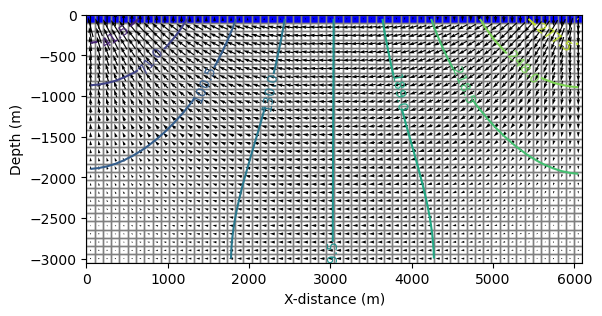

In [19]:
# Create the headfile and budget file objects
os.chdir(modelpath)
headobj = bf.HeadFile(modelname + '.hds')
times = headobj.get_times()
cbb = bf.CellBudgetFile(modelname + '.cbc')

#read in data for first time step (they're all the same for steady state...)
time=1.0

print('*****Processing time: ', time)
head = headobj.get_data(totim=time)

# Setup contour parameters
levels = np.linspace(int(np.min(head)), int(np.max(head)), 11)
extent = (delr / 2., Lx - delr / 2., delv / 2., (ztop-zbot) - delv / 2.)
print('Levels: ', levels)
print('Extent: ', extent)
# Make the plots

#Print statistics
print('Head statistics')
print('  min: ', head.min())
print('  max: ', head.max())
print('  std: ', head.std())

# Extract flow vector components
vx = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]
vz = -1*cbb.get_data(text='FLOW LOWER FACE', totim=time)[0] #multiply by -1 to deal with negative z coordinates.
vy = np.zeros(vz.shape) #no flow in column direction

#Create the plot
f = plt.figure()
ax = plt.subplot(1, 1, 1, aspect='equal')

#use flopy vizualization methods (all of this can be done with straight mpl...)
pmv = flopy.plot.PlotCrossSection(model=mf, line={'row':0})
qm = pmv.plot_ibound()
lc = pmv.plot_grid()
cs = pmv.contour_array(head, levels=levels)
plt.clabel(cs, inline=1, fontsize=10, fmt='%1.1f')
quiver = pmv.plot_vector(vx,vy,vz, head = head)
ax.set_xlabel('X-distance (m)')
ax.set_ylabel('Depth (m)')